# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import torch
import torchinfo
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
import polcanet.reports as report
import polcanet.utils as ut
import polcanet.mlutils as mlut
from polcanet import PolcaNet

In [5]:
import random

random_seed = 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
with_labels = False
if with_labels:
    name = "MNIST_dataset_labels"
else:
    name = "MNIST_dataset"
    
exp = ut.ExperimentInfoHandler(
    name=name,
    description="POLCA-Net on MNIST dataset",
    random_seed=random_seed,
)
ut.set_save_fig(True)
ut.set_save_path(str(exp.get_experiment_folder()))
print(f"Saving data: {ut.get_save_fig()}, saving in path: {ut.get_save_path()}")

Saving data: True, saving in path: /data1/deploy/polcanet/examples/notebooks/experiments/MNIST_dataset


### Load dataset

In [6]:
from torchvision.datasets import MNIST
mnist_trainset = MNIST(root="data/MNIST", train=True, download=True, transform=None)
mnist_testset = MNIST(root="data/MNIST", train=False, download=True, transform=None)

In [7]:
train_dataset = mnist_trainset.data.reshape(-1, 28, 28) / 255.0
eval_dataset = mnist_testset.data.reshape(-1, 28, 28) / 255.0
y = mnist_trainset.targets.numpy()
y_test = mnist_testset.targets.numpy()

labels = np.unique(y) if with_labels else None

X = np.array(train_dataset.numpy(), dtype=np.float32)
X = np.squeeze(X)
print(X.min(),X.max())
X_test = np.array(eval_dataset.numpy(), dtype=np.float32)
X_test = np.squeeze(X_test)
train_dataset.shape, eval_dataset.shape, X.shape,X_test.shape, y.shape, y_test.shape, labels

0.0 1.0


(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 (60000, 28, 28),
 (10000, 28, 28),
 (60000,),
 (10000,),
 None)

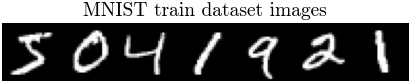

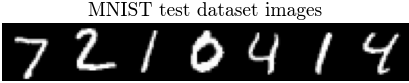

In [8]:
ut.set_fig_prefix("sin_train")
ut.plot_train_images(X, "MNIST train dataset images",cmap="gray", n=7)
ut.set_fig_prefix("sin_test")
ut.plot_train_images(X_test, "MNIST test dataset images",cmap="gray", n=7)

### Fit standard sklearn PCA

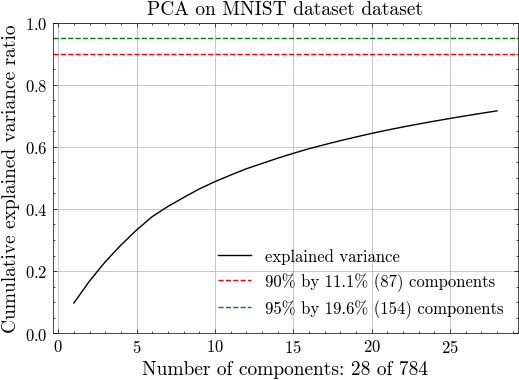

In [9]:
n_components = 28 #  Heuristic sqrt(image size)
pca = ut.perform_pca(X, n_components=n_components, title="PCA on MNIST dataset dataset")
Xpca = pca.transform(np.squeeze(X.reshape(X.shape[0], -1)))
plt.show()

### Fit POLCANet

In [10]:
N = X[0].shape[0]
M = X[0].shape[1]

In [11]:
from polcanet.aencoders import ConvEncoder, LinearDecoder

act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"


encoder = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=8,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=512,
    num_layers=5,
    act_fn=act_fn,
    bias=False,
)

model = PolcaNet(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    alpha=1e-2,  # ortgogonality loss
    beta=1e-2,  # variance sorting loss
    gamma=1e-6,  # variance reduction loss
    class_labels=labels,  # class labels for supervised in case labels is not None
)

print(model)
summary = torchinfo.summary(
    model,
    (1, input_dim[0], input_dim[1]),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
ut.save_text(str(model), "model.txt")
ut.save_text(str(summary), "model_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (2): SiLU()
        (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): SiLU()
        (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (6): SiLU()
        (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (8): SiLU()
        (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (10): SiLU()
        (11): Flatten(start_dim=1, end_dim=-1)
        (12): Linear(in_features=512, out_features=112, bias=True)
        (13): SiLU()
        (14): Linear(in_features=112, out_features=28, bias=True)
      )
    )
    (post_encoder): Sequential(
      (0): Linear(in_features=28, out_features=28, bias=True)
      (1)

In [12]:
model.to(device)
model.train_model(data=X,y=y,batch_size=512, num_epochs=500, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Final metrics at epoch: 500
Total Loss: 0.003574
Reconstruction Loss: 0.003514
Orthogonality Loss: 0.003705
Center of Mass Loss: 0.002299
Variance Reduction Loss: 0.0184


In [13]:
model.train_model(data=X,y=y,batch_size=512, num_epochs=100, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Final metrics at epoch: 100
Total Loss: 0.003214
Reconstruction Loss: 0.003163
Orthogonality Loss: 0.003235
Center of Mass Loss: 0.001798
Variance Reduction Loss: 0.02146


In [14]:
model.train_model(data=X,y=y, batch_size=512, num_epochs=100, report_freq=10, lr=1e-5)

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Final metrics at epoch: 100
Total Loss: 0.003162
Reconstruction Loss: 0.003113
Orthogonality Loss: 0.00312
Center of Mass Loss: 0.001753
Variance Reduction Loss: 0.02178


## Evaluate results

Loss Interaction Analysis Report:
Total interactions: 48480
Total conflicts: 8437
Overall conflict rate: 0.1740

Pairwise Statistics (sorted by similarity):


,loss1,loss2,interactions,conflicts,conflict_rate,avg_similarity,relationship
0,com,var,8080,3596,0.4450,-0.0866,Weakly Conflicting
1,rec,com,8080,1682,0.2082,-0.0045,Weakly Conflicting
2,rec,var,8080,1703,0.2108,-0.0005,Weakly Conflicting
3,ort,var,8080,609,0.0754,0.0086,Weakly Cooperative
4,ort,com,8080,367,0.0454,0.0474,Weakly Cooperative
5,rec,ort,8080,480,0.0594,0.1456,Strongly Cooperative


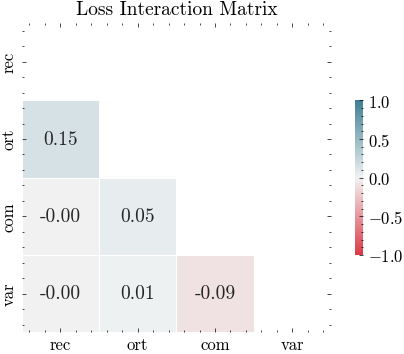

In [26]:
ut.set_fig_prefix("train")
model.loss_analyzer.print_report()
model.loss_analyzer.plot_correlation_matrix()

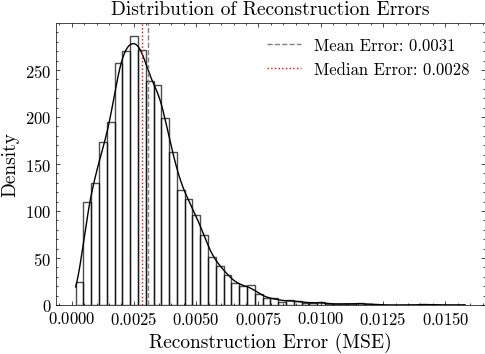

Mean Reconstruction Error: 0.0031
Median Reconstruction Error: 0.0028
Min Reconstruction Error: 0.0002
Max Reconstruction Error: 0.0158


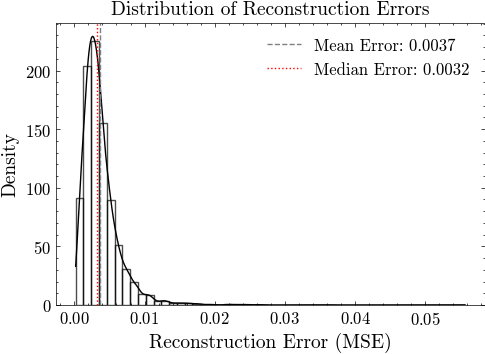

Mean Reconstruction Error: 0.0037
Median Reconstruction Error: 0.0032
Min Reconstruction Error: 0.0002
Max Reconstruction Error: 0.0557


In [ ]:
ut.set_fig_prefix("train")
report.analyze_reconstruction_error(model, X)
ut.set_fig_prefix("test")
report.analyze_reconstruction_error(model, X_test)

In [16]:
latents, reconstructed = model.predict(X)

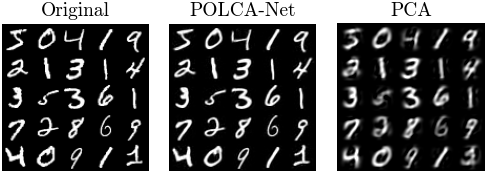

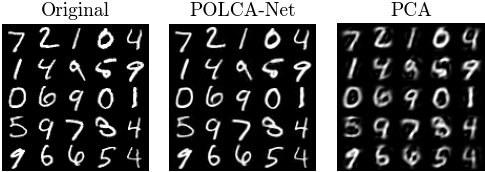

In [17]:
# Assuming images are properly defined as before
images = X[0:25]
ut.set_fig_prefix("train")
ut.plot_reconstruction_comparison(model,pca,images,cmap="gray",nrow=5)
images = X_test[0:25]
ut.set_fig_prefix("test")
ut.plot_reconstruction_comparison(model,pca,images,cmap="gray",nrow=5)

,Metric,Value
0,Mean cosine similarity,0.031755
1,Median cosine similarity,0.024823
2,Standard deviation of cosine similarity,0.034720
3,Max cosine similarity,0.379304
4,Min cosine similarity,0.000026


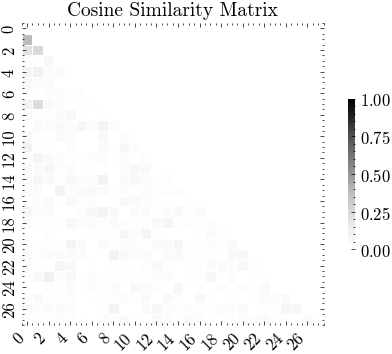

,Metric,Value
0,Mean mutual information,0.013168
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.037712
3,Max mutual information,0.803801
4,Min mutual information,0.000000


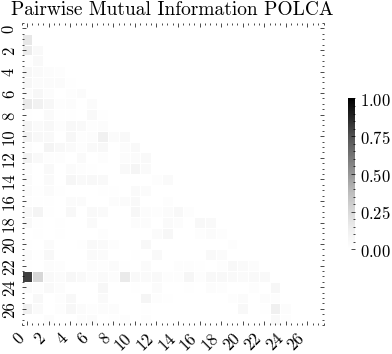

,Metric,Value
0,Mean mutual information,0.011812
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.025117
3,Max mutual information,0.214970
4,Min mutual information,0.000000


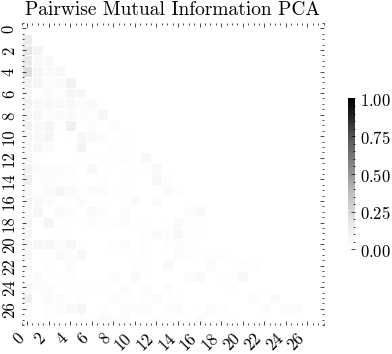

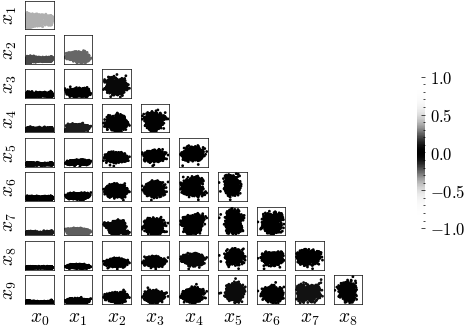

,Metric,Value
0,Mean cosine similarity,0.035836
1,Median cosine similarity,0.028428
2,Standard deviation of cosine similarity,0.034187
3,Max cosine similarity,0.386488
4,Min cosine similarity,0.000104


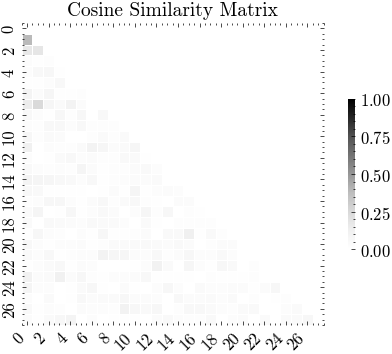

,Metric,Value
0,Mean mutual information,0.013943
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.040009
3,Max mutual information,0.849022
4,Min mutual information,0.000000


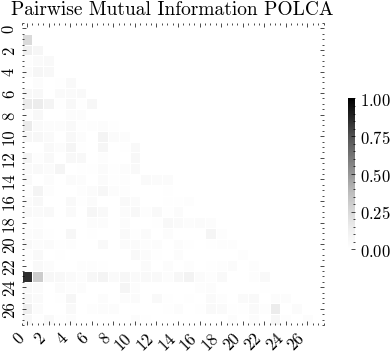

,Metric,Value
0,Mean mutual information,0.012026
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.023633
3,Max mutual information,0.183888
4,Min mutual information,0.000000


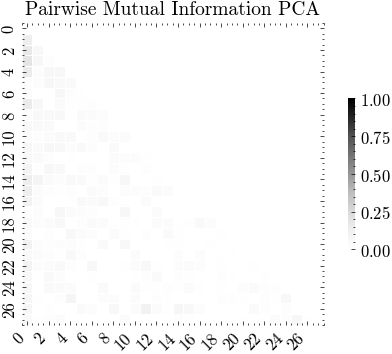

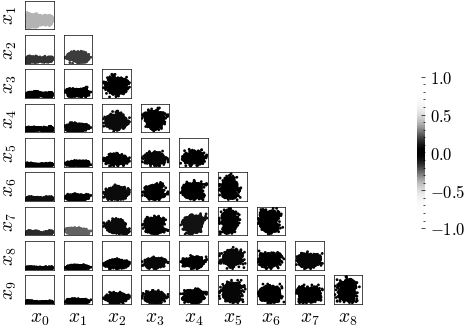

In [18]:
ut.set_fig_prefix("train")
report.orthogonality_test_analysis(model,pca, X)
ut.set_fig_prefix("test")
report.orthogonality_test_analysis(model,pca, X_test)

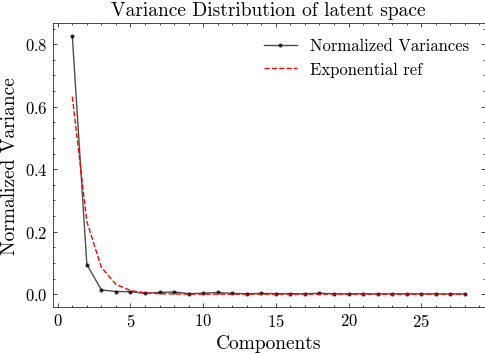

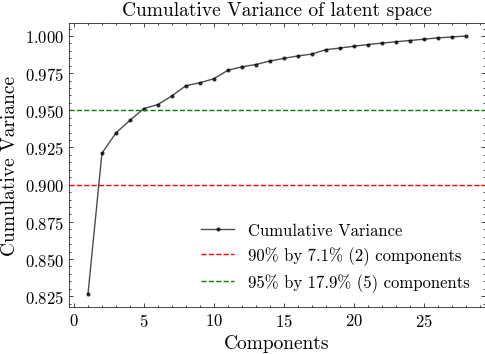

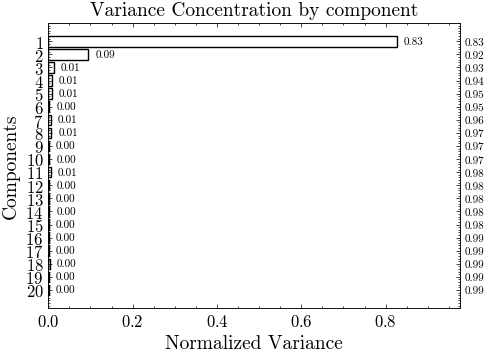

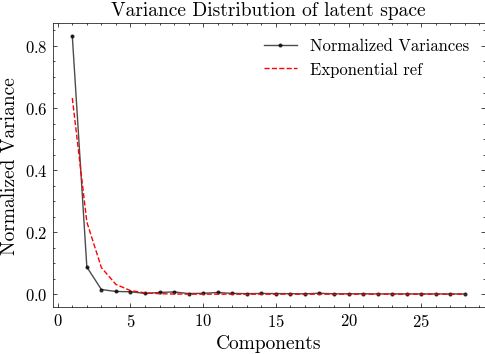

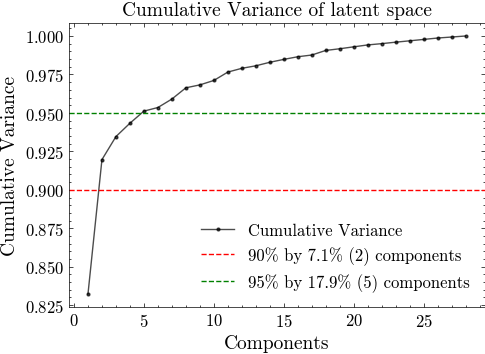

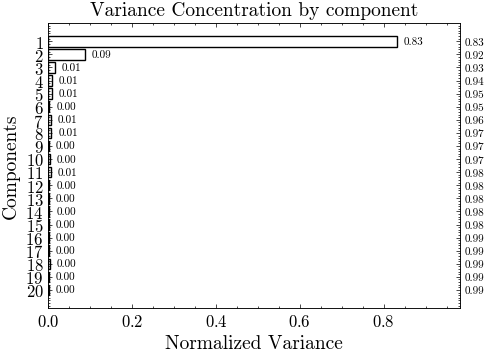

In [19]:
ut.set_fig_prefix("train")
report.variance_test_analysis(model, X)
ut.set_fig_prefix("test")
report.variance_test_analysis(model, X_test)

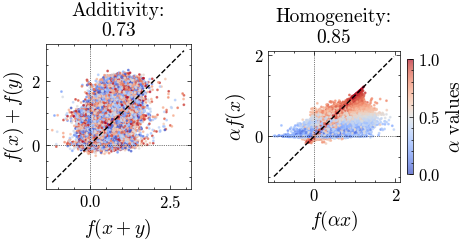

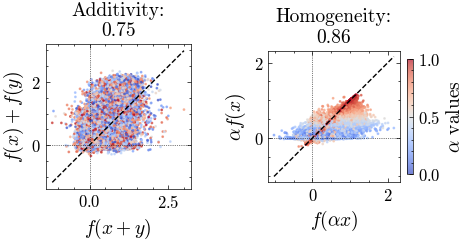

In [20]:
ut.set_fig_prefix("train")
report.linearity_tests_analysis(model, X,alpha_min=0, num_samples=200)
ut.set_fig_prefix("test")
report.linearity_tests_analysis(model, X_test,alpha_min=0, num_samples=200)

In [21]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _, _ = ut.plot2d_analysis(Xpca, y, title="PCA transform", legend=True)
with o2:
    _, _ = ut.plot2d_analysis(latents, y, title="POLCA-Net latent",  legend=True)
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

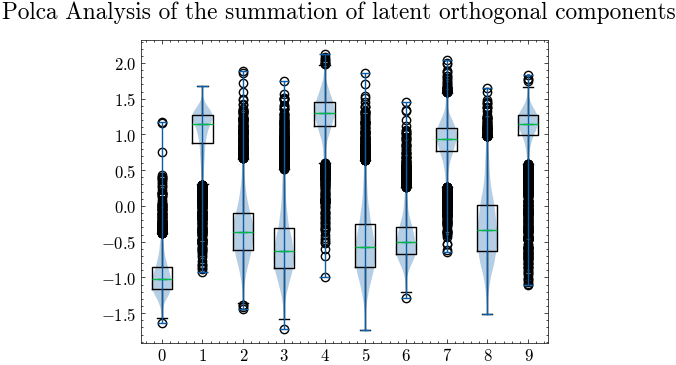

In [22]:
latents, reconstructed = model.predict(X)
vectors = []
labels = [str(i) for i in range(10)]
for c, label in enumerate(labels):
    vectors.append(np.sum(latents[y == c, :], axis=1))


plt.boxplot(vectors, tick_labels=labels)
plt.violinplot(vectors, showmeans=False, showmedians=True)
plt.suptitle("Polca Analysis of the summation of latent orthogonal components")
plt.show()

## Test Classification with two components on PCA vs POLCA Net

In [23]:
_ = ut.make_classification_report(model, pca, X,y, X_test, y_test, n_components=pca.n_components)

Classification Performance Metrics DataFrame:


Accuracy       Precision       Recall        \
Transformation                 PCA POLCA       PCA POLCA    PCA POLCA   
Classifier          Split                                               
Linear SVM          Test      0.92  0.97      0.92  0.97   0.92  0.97   
                    Train     0.92  0.98      0.92  0.98   0.92  0.98   
Logistic Regression Test      0.89  0.97      0.89  0.97   0.89  0.97   
                    Train     0.89  0.96      0.89  0.96   0.89  0.96   
Perceptron          Test      0.83  0.94      0.83  0.94   0.83  0.94   
                    Train     0.82  0.94      0.82  0.94   0.82  0.94   
Ridge Classifier    Test      0.83  0.93      0.83  0.93   0.83  0.93   
                    Train     0.82  0.92      0.82  0.93   0.82  0.92   

                          F1-Score        
Transformation                 PCA POLCA  
Classifier          Split                 
Linear SVM          Test      0.92  0.97  
                    Train     0.92  0.98  
Logistic Regression Test      0.89  0.97  
                    Train     0.89  0.96  
Perceptron          Test      0.83  0.94  
                    Train     0.82  0.94  
Ridge Classifier    Test      0.83  0.93  
                    Train     0.82  0.92

In [24]:
_ = ut.make_classification_report(model, pca, X,y, X_test, y_test, n_components=pca.n_components//2)

Classification Performance Metrics DataFrame:


Accuracy       Precision       Recall        \
Transformation                 PCA POLCA       PCA POLCA    PCA POLCA   
Classifier          Split                                               
Linear SVM          Test      0.88  0.94      0.88  0.94   0.88  0.94   
                    Train     0.87  0.94      0.87  0.94   0.87  0.94   
Logistic Regression Test      0.85  0.93      0.85  0.93   0.85  0.93   
                    Train     0.84  0.93      0.84  0.93   0.84  0.93   
Perceptron          Test      0.76  0.86      0.76  0.87   0.76  0.86   
                    Train     0.75  0.85      0.75  0.86   0.75  0.85   
Ridge Classifier    Test      0.75  0.88      0.77  0.89   0.75  0.88   
                    Train     0.74  0.87      0.76  0.88   0.74  0.87   

                          F1-Score        
Transformation                 PCA POLCA  
Classifier          Split                 
Linear SVM          Test      0.88  0.94  
                    Train     0.87  0.94  
Logistic Regression Test      0.85  0.93  
                    Train     0.84  0.93  
Perceptron          Test      0.75  0.86  
                    Train     0.74  0.85  
Ridge Classifier    Test      0.72  0.88  
                    Train     0.71  0.87

In [25]:
experiment_data = {
    "MNIST": (
        X_test,
        model,
        pca,
    ),
}
_ = ut.image_metrics_table(experiment_data)

,NMSE,PSNR,SSI
Method,,,
POLCA MNIST,0.1757,25.2076,0.9210
PCA MNIST,0.4118,17.6297,0.6405
